In [1]:
import ee
import datetime
import os
import itertools
import sys

from pprint import pprint
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geemap

import subprocess
from subprocess import PIPE

In [2]:
ee.Initialize()

In [3]:
# append upper folder into sys-path during run time so we can
# import our own moduls
sys.path.append('../Process_1_GEE_Python_Classification/')
from BackGround_modules.Class_3_Calculate_the_accuracy import Accuracy_assesment

In [4]:
# import boundry 
North_China_Plain = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")
North_China_Plain_city = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_city_boundary")
North_China_Plain_province = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_province_boundry")
North_China_Plain_County = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_County")
North_China_Plain_Towm = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Town")

# define the zoning boundy for area calculation
Zoning_shp = North_China_Plain_province

In [5]:
# import the untouched control points, which are diveded by a random column with a 101 random state
Sample_Landsat  = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Sample_Points/Control_points")\
                    .randomColumn('split', 101)\
                    .filterMetadata('split','less_than',0.25)

Sample_Sentinel = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Sample_Points/Sentinel_2017_2019")\
                    .randomColumn('split', 101)\
                    .filterMetadata('split','less_than',0.25)


# because the last two decade used different untouched sample, 
# so here we merge them together
Untouched_sample = [Sample_Landsat] + [Sample_Sentinel] 

### calculate the area change of the classification

In [6]:
# initilize the remap dictionary
Re_dict = dict(zip(range(1980,2020),range(40,0,-1)))

##### Import my result and reference maps

In [7]:
# get the classification of this study
My_img = ee.Image("users/wangjinzhulala/North_China_Plain_Python/classificatioin_temporal_checked/Mosaic_only_forward")

# get the value dict of my result 
My_value = dict(zip(range(1991,2019,3),range(10,0,-1)))

# unstack the img into seperate bands and add property to it
My_bands = []

for k,v in My_value.items():
    
    band = My_img.gte(v)
    band = band.setMulti(['Source','My','Year',k,'Scale',30])
    My_bands.append(ee.Image(band))
    
#_________remap_the_pixel_value_for_temporal_comparasion______

# 1)_get the value pairs 
left_val = []
right_val = []

for k,v in My_value.items():
    left_val.append(v)
    right_val.append(Re_dict[k])
    
# 2) remap the img
My_img_re = My_img.remap(left_val,right_val,0).setMulti(['Scale',30])
    

In [8]:
# get the GAIA classification product
GAIA_img = ee.Image("users/wangjinzhulala/North_China_Plain_Python/Reference_classification/GAIA_Gong_1985_2018")

# get the GAIA value dict
GAIA_value = dict(zip(range(1985,2019),range(34,0,-1)))

# unstack the img into seperate bands and add property to it
GAIA_bands = []

for k,v in GAIA_value.items():
    band = GAIA_img.gte(v)
    band = band.setMulti(['Source','GAIA','Year',k,'Scale',30])
    GAIA_bands.append(ee.Image(band))
    
#_________remap_the_pixel_value_for_temporal_comparasion______

# 1)_get the value pairs 
left_val = []
right_val = []

for k,v in GAIA_value.items():
    left_val.append(v)
    right_val.append(Re_dict[k])
    
# 2) remap the img
GAIA_re = GAIA_img.remap(left_val,right_val,0).setMulti(['Scale',30])

In [9]:
# get the Global Impervious Surface of 2015
GIS_2015 = ee.Image("users/wangjinzhulala/North_China_Plain_Python/Reference_classification/Global_Impervious_Surface_2015_NCP")\
             .remap([1,2],[0,1])\
             .rename('b1')

# Add propertied to the img
GIS_2015 = ee.Image(GIS_2015.setMulti(['Source','GIS','Year',2015,'Scale',30]))


#_________remap_the_pixel_value_for_temporal_comparasion______
GIS_2015_re = GIS_2015.remap([0,1],[0,5]).setMulti(['Scale',30])    

In [10]:
# import the Global_urban_Liu_2018
path_liu = 'users/wangjinzhulala/North_China_Plain_Python/Reference_classification/Global_urban_Liu_2018'
Global_urban_Liu_1990_2015 = subprocess.run(f'earthengine ls {path_liu}', stdout=subprocess.PIPE)

# get the avaliable years of this dataset
year_avaliable = [1980,1990,1995,2000,2005,2010,2015]

# mosaic the Img_Col to single img
Global_urban_Liu_bands = []

for t in year_avaliable:  
  
    band =  ee.ImageCollection([ee.Image(s) for s in str(Global_urban_Liu_1990_2015.stdout).split('\\r\\n') if str(t) in s]).mosaic()    
    band = band.setMulti(['Source','Global Urban Liu','Year',t,'Scale',30])
    
    Global_urban_Liu_bands.append(ee.Image(band))
    
    
#_________remap_the_pixel_value_for_temporal_comparasion______

# 1)_get the value pairs 
Global_urban_Liu_re_list = []

for img in Global_urban_Liu_bands:
    
    # remap the img
    year = int(img.get('Year').getInfo())
    re_map_val = Re_dict[year]
    img_re = img.remap([0,1],[0,re_map_val])
    
    # store the img_re to list
    Global_urban_Liu_re_list.append(img_re)
    
# 2) create the mosaic from img_res
Global_urban_Liu_re = ee.ImageCollection(Global_urban_Liu_re_list).max().setMulti(['Scale',30])

In [11]:
# import the ESA global-human-settlement data
GHSL = ee.Image("users/wangjinzhulala/North_China_Plain_Python/Reference_classification/GHSL_NCP")

# get the GAIA value dict
GHSL_value ={2015:3,2000:4,1990:5}

# unstack the img into seperate bands and add property to it
GHSL_bands = []

for k,v in GHSL_value.items():
    band = GHSL.gte(v)
    band = band.setMulti(['Source','GHSL','Year',k,'Scale',38])
    GHSL_bands.append(ee.Image(band))
    
#_________remap_the_pixel_value_for_temporal_comparasion______

# 1)_get the value pairs 
GHSL_re_list = []

for img in GHSL_bands:
    
    # remap the img
    year = int(img.get('Year').getInfo())
    re_map_val = Re_dict[year]
    img_re = img.remap([0,1],[0,re_map_val]).toInt8()
    
    # store the img_re to list
    GHSL_re_list.append(img_re)
    
# 2) create the mosaic from img_res
GHSL_re = ee.ImageCollection(GHSL_re_list).max().setMulti(['Scale',38])

In [12]:
# import the MODIS-Landcover
MODIS = [ee.Image(ee.Image(f'MODIS/006/MCD12Q1/{year}_01_01').select('LC_Type1').rename('b1')\
           .eq(13).setMulti(['Source','MODIS','Year',year,'Scale',500]))
         for year in range(2001,2020)]


#_________remap_the_pixel_value_for_temporal_comparasion______

# 1)_get the value pairs 
MODIS_re_list = []

for img in MODIS:
    
    # remap the img
    year = int(img.get('Year').getInfo())
    re_map_val = Re_dict[year]
    img_re = img.remap([0,1],[0,re_map_val]).toInt8()
    
    # store the img_re to list
    MODIS_re_list.append(img_re)
    
# 2) create the mosaic from img_res
MODIS_re = ee.ImageCollection(MODIS_re_list).max().setMulti(['Scale',500])

In [13]:
# import the ESA Climate Change Initiative
# Landcover values: http://maps.elie.ucl.ac.be/CCI/viewer/download/ESACCI-LC-QuickUserGuide-LC-Maps_v2-0-7.pdf

ESACCI_1992_2015 = ee.Image("users/wangjinzhulala/North_China_Plain_Python/Reference_classification/ESACCI_1992_2015")

# get the GAIA value dict
ESACCI_value = dict(zip(range(1992,2016),[f'b{i}' for i in range(1,25)]))

# unstack the img into seperate bands and add property to it
ESACCI_bands = []

for k,v in ESACCI_value.items():
    band = ESACCI_1992_2015.select(v).eq(190)
    band = band.setMulti(['Source','ESACCI','Year',k,'Scale',300])
    ESACCI_bands.append(ee.Image(band))
    
#_________remap_the_pixel_value_for_temporal_comparasion______

# 1)_get the value pairs 
ESACCI_re_list = []

for img in ESACCI_bands:
    
    # remap the img
    year = int(img.get('Year').getInfo())
    re_map_val = Re_dict[year]
    img_re = img.remap([0,1],[0,re_map_val]).toInt8()
    
    # store the img_re to list
    ESACCI_re_list.append(img_re)
    
# 2) create the mosaic from img_res
ESACCI_re = ee.ImageCollection(ESACCI_re_list).max().setMulti(['Scale',300])

In [14]:
# import the Global Urban area from He

He_years = [1992,1996,2000,2006,2010,2016]

Global_urban_He_1992_2016 = [ee.Image(ee.Image(f"users/wangjinzhulala/North_China_Plain_Python/Reference_classification/Global_urban_He_1992_2016/Global_Urban_Land_{year}")\
                                        .setMulti(['Source','Global Urban He','Year',year,'Scale',1000]))
                             for year in He_years]


#_________remap_the_pixel_value_for_temporal_comparasion______

# 1)_get the value pairs 
Global_urban_He_re_list = []

for img in Global_urban_He_1992_2016:
    
    # remap the img
    year = int(img.get('Year').getInfo())
    re_map_val = Re_dict[year]
    img_re = img.remap([0,1],[0,re_map_val]).toInt8()
    
    # store the img_re to list
    Global_urban_He_re_list.append(img_re)
    
# 2) create the mosaic from img_res
Global_urban_He_re = ee.ImageCollection(Global_urban_He_re_list).max().setMulti(['Scale',1000])

In [15]:
Grump_1995 = ee.Image(ee.Image("users/wangjinzhulala/North_China_Plain_Python/Reference_classification/GRUMP_1995")\
                        .eq(2)\
                        .setMulti(['Source','GRUMP 1995','Year',1995,'Scale',1000]))

#_________remap_the_pixel_value_for_temporal_comparasion______
GIS_2015_re = GIS_2015.remap([0,1],[0,5]).setMulti(['Scale',1000])    

##### Export the re_map imgs

In [16]:
ALL_re_maps =  [My_img_re, GAIA_re,  Global_urban_Liu_re, GHSL_re, MODIS_re,ESACCI_re, Global_urban_He_re]
ALL_re_maps_names =  ['My_img_re', 'GAIA_re',  'Global_urban_Liu_re', 'GHSL_re', 'MODIS_re', 'ESACCI_re', 'Global_urban_He_re']

In [20]:
for img,name in zip(ALL_re_maps,ALL_re_maps_names):
    
    # cat the img to ee.Image
    img = ee.Image(img)
    
    # get the scale for export
    scale = img.get('Scale').getInfo()
    
    # built the export task
    task = ee.batch.Export.image.toCloudStorage(img,
                                                description=name,
                                                bucket='north_china_plain',
                                                fileNamePrefix=name,
                                                region=North_China_Plain.geometry().bounds(),
                                                scale=scale,
                                                maxPixels=int(1e13))
    task.start()
    
    # print out the process
    print(f'{name} has been exported to GS!')

My_img_re has been exported to GS!
GAIA_re has been exported to GS!
Global_urban_Liu_re has been exported to GS!
GHSL_re has been exported to GS!
MODIS_re has been exported to GS!
ESACCI_re has been exported to GS!
Global_urban_He_re has been exported to GS!


##### Combine all bands together

In [17]:
All_bands = My_bands + GAIA_bands + [GIS_2015] + Global_urban_Liu_bands + \
            GHSL_bands + MODIS + ESACCI_bands + Global_urban_He_1992_2016 + [Grump_1995]

In [18]:
# prepare one img and add it to map
in_img = Global_urban_He_re
source = in_img.get('Source').getInfo()
year = in_img.get('Year').getInfo()
name = f'{source}_{year}'

Map = geemap.Map()
Map.add_basemap('HYBRID')
Map.setCenter(115.6491, 34.4384,10)

Map.addLayer(ee.Image(in_img),{'min':0,'max':40},name)
Map

Map(center=[34.4384, 115.6491], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButt…

##### Calculate the area changes and accuracy 

In [17]:
# initiate an empty list to hold the result
Stats_df_list = []
Accuracy_df_lis = []

for band in All_bands:
    
    band = band.rename('classification')
    source = band.get('Source').getInfo()
    year = band.get('Year').getInfo()
    scale = band.get('Scale').getInfo()
    
    #_____________________________compute the area__________________
    
    # get the pixel count 
    Stats   = band.reduceRegions(reducer     = ee.Reducer.sum(), 
                                 collection  = Zoning_shp, 
                                 scale       = scale,
                                 tileScale   = 1).select(['EN_Name','sum']).getInfo()
    
    # store the pixel count into a df 
    sum_df = pd.DataFrame([i['properties'] for i in Stats['features']])
    sum_df['year'] = year
    sum_df['Source'] = source
    sum_df['Scale'] = scale
    
    # append the area_sum to df_list
    Stats_df_list.append(sum_df)
    
    #_______________________________compute the accuracy _________________________
    
    # determine the sample sets
    if year < 2014:
        sample = Untouched_sample[0]
    else:
        sample = Untouched_sample[1]
        
    # extract the img pixel value to test_sample
    sample_with_classification   = band.sampleRegions(collection = sample, 
                                                      properties = ['Built'], 
                                                      scale      = scale)
    
    # compute the accuracy and put them into a df
    Acc_dict = {}
    Acc_dict[(source,year)] = Accuracy_assesment(sample_with_classification).Stp_1_Calculate_Accuracy()
    Acc_df = pd.DataFrame(Acc_dict).T
    
    Accuracy_df_lis.append(Acc_df)    
    
    # print out the process
    print(f'Area/Accuracy calculation of {source}_{year} of resolution {scale} finished!')

Area/Accuracy calculation of My_1991 of resolution 30 finished!
Area/Accuracy calculation of My_1994 of resolution 30 finished!
Area/Accuracy calculation of My_1997 of resolution 30 finished!
Area/Accuracy calculation of My_2000 of resolution 30 finished!
Area/Accuracy calculation of My_2003 of resolution 30 finished!
Area/Accuracy calculation of My_2006 of resolution 30 finished!
Area/Accuracy calculation of My_2009 of resolution 30 finished!
Area/Accuracy calculation of My_2012 of resolution 30 finished!
Area/Accuracy calculation of My_2015 of resolution 30 finished!
Area/Accuracy calculation of My_2018 of resolution 30 finished!
Area/Accuracy calculation of GAIA_1985 of resolution 30 finished!
Area/Accuracy calculation of GAIA_1986 of resolution 30 finished!
Area/Accuracy calculation of GAIA_1987 of resolution 30 finished!
Area/Accuracy calculation of GAIA_1988 of resolution 30 finished!
Area/Accuracy calculation of GAIA_1989 of resolution 30 finished!
Area/Accuracy calculation of G

../Process_1_GEE_Python_Classification\BackGround_modules\Class_3_Calculate_the_accuracy.py:82: RuntimeWarning: invalid value encountered in true_divide
  precision_acc = np.diag(self.error_matrix)/np.sum(self.error_matrix,axis=0)


Area/Accuracy calculation of Global Urban He_1992 of resolution 1000 finished!
Area/Accuracy calculation of Global Urban He_1996 of resolution 1000 finished!
Area/Accuracy calculation of Global Urban He_2000 of resolution 1000 finished!
Area/Accuracy calculation of Global Urban He_2006 of resolution 1000 finished!
Area/Accuracy calculation of Global Urban He_2010 of resolution 1000 finished!
Area/Accuracy calculation of Global Urban He_2016 of resolution 1000 finished!
Area/Accuracy calculation of GRUMP 1995_1995 of resolution 1000 finished!


##### Save result_df  to disk

In [20]:
# # store the area change to a df
# Area_stack = pd.concat(Stats_df_list)

# # compute the area_km2
# Area_stack['area_km2'] = Area_stack['sum'] * Area_stack['Scale'] * Area_stack['Scale']/1000/1000

# # save to dis
# Area_stack.to_csv('./Result/Area_change.csv',index=False)

# read csv
Area_stack = pd.read_csv('./Result/Area_change.csv')

In [22]:
# # Formatting the GAIA_accuracy dataframe
# Accuracy_df = pd.concat(Accuracy_df_lis).reset_index()
# Accuracy_df.columns =['Source','year','Overall_ACC', 'Precisioin_built','Precisioin_non_built', 'Recall_built', 'Recall_non_built']

# # save to disk
# Accuracy_df.to_csv('./Result/Accuracy_comparision.csv',index=False)

# load the df
Accuracy_df = pd.read_csv('./Result/Accuracy_comparision.csv')

#### Observe that there is a noticibel dirrerence between my result and other datasets

In [23]:
Area_stack

,EN_Name,sum,year,Source,Scale,area_km2
0,Shandong,1.163410e+07,1991,My,30,10470.690053
1,Henan,9.259521e+06,1991,My,30,8333.569256
2,Beijing,9.284888e+05,1991,My,30,835.639938
3,Tianjin,8.087451e+05,1991,My,30,727.870624
4,Hebei,7.989920e+06,1991,My,30,7190.927612
...,...,...,...,...,...,...
730,Beijing,5.295820e+03,1995,GRUMP 1995,1000,5295.819608
731,Tianjin,3.727698e+03,1995,GRUMP 1995,1000,3727.698039
732,Hebei,3.239178e+04,1995,GRUMP 1995,1000,32391.776471
733,Anhui,2.555672e+04,1995,GRUMP 1995,1000,25556.717647


In [39]:
Accuracy_df

,Source,year,Overall_ACC,Precisioin_built,Precisioin_non_built,Recall_built,Recall_non_built
0,My,1991,93.99,100.00,89.25,88.00,100.00
1,My,1994,94.39,100.00,89.90,88.81,100.00
2,My,1997,94.39,100.00,89.90,88.81,100.00
3,My,2000,94.55,99.89,90.22,89.21,99.90
4,My,2003,94.55,99.77,90.29,89.31,99.80
...,...,...,...,...,...,...,...
100,Global Urban He,2000,86.27,86.27,NaN,100.00,0.00
101,Global Urban He,2006,84.38,84.38,NaN,100.00,0.00
102,Global Urban He,2010,84.21,84.21,NaN,100.00,0.00
103,Global Urban He,2016,77.33,77.33,NaN,100.00,0.00


In [24]:
Area_each_source_year = Area_stack.groupby(['Source','year']).sum()
Area_each_source_year = Area_each_source_year.reset_index()
Area_each_source_year

,Source,year,sum,Scale,area_km2
0,ESACCI,1992,1.501502e+05,2100,13513.518353
1,ESACCI,1993,1.554921e+05,2100,13994.286000
2,ESACCI,1994,1.603716e+05,2100,14433.441882
3,ESACCI,1995,1.652436e+05,2100,14871.921176
4,ESACCI,1996,1.701964e+05,2100,15317.678824
...,...,...,...,...,...
100,My,2006,8.473420e+07,210,76260.783844
101,My,2009,9.692123e+07,210,87229.104992
102,My,2012,1.108309e+08,210,99747.769631
103,My,2015,1.257254e+08,210,113152.874044


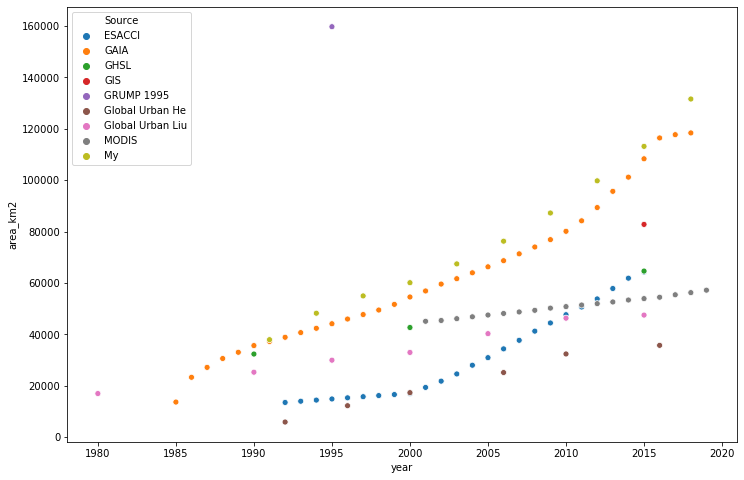

In [25]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=Area_each_source_year,
            x='year',
            y='area_km2',
            hue='Source')

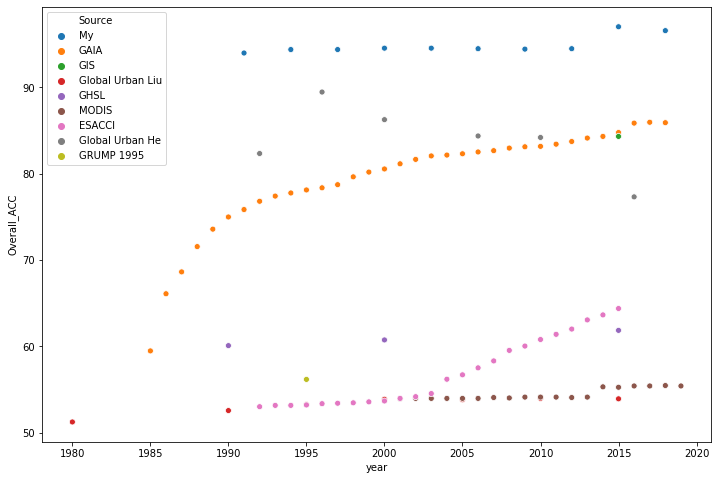

In [26]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=Accuracy_df,
            x='year',
            y='Overall_ACC',
            hue='Source')